In [1]:
import os
import statistics
import time
#from imblearn.over_sampling import *
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest, AdaBoostClassifier, RandomForestRegressor, RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from sklearn.manifold import TSNE
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as score, recall_score
from sklearn.preprocessing import RobustScaler, MinMaxScaler, QuantileTransformer, StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
# import umap
from sklearn import tree
#import graphviz

import tensorflow as tf
from tensorflow.keras import layers, models
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv1D, MaxPooling1D, Conv1DTranspose, Flatten, Dropout, Input, concatenate, LSTM,UpSampling1D, Reshape, TimeDistributed
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from keras.models import Model

import pickle
import warnings

/cluster/raid/home/sape/miniconda3/envs/adversarial/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
2023-07-24 19:26:25.227007: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-24 19:26:34.739747: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-07-24 19:26:34.739938: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
def window_nd(a, window, steps = None, axis = None, gen_data = False):
        """
        Create a windowed view over `n`-dimensional input that uses an 
        `m`-dimensional window, with `m <= n`
        
        Parameters
        -------------
        a : Array-like
            The array to create the view on
            
        window : tuple or int
            If int, the size of the window in `axis`, or in all dimensions if 
            `axis == None`
            
            If tuple, the shape of the desired window.  `window.size` must be:
                equal to `len(axis)` if `axis != None`, else 
                equal to `len(a.shape)`, or 
                1
                
        steps : tuple, int or None
            The offset between consecutive windows in desired dimension
            If None, offset is one in all dimensions
            If int, the offset for all windows over `axis`
            If tuple, the steps along each `axis`.  
                `len(steps)` must me equal to `len(axis)`
    
        axis : tuple, int or None
            The axes over which to apply the window
            If None, apply over all dimensions
            if tuple or int, the dimensions over which to apply the window

        gen_data : boolean
            returns data needed for a generator
    
        Returns
        -------
        
        a_view : ndarray
            A windowed view on the input array `a`, or `a, wshp`, where `whsp` is the window shape needed for creating the generator
            
        """
        ashp = np.array(a.shape)
        
        if axis != None:
            axs = np.array(axis, ndmin = 1)
            assert np.all(np.in1d(axs, np.arange(ashp.size))), "Axes out of range"
        else:
            axs = np.arange(ashp.size)
            
        window = np.array(window, ndmin = 1)
        assert (window.size == axs.size) | (window.size == 1), "Window dims and axes don't match"
        wshp = ashp.copy()
        wshp[axs] = window
        assert np.all(wshp <= ashp), "Window is bigger than input array in axes"
        
        stp = np.ones_like(ashp)
        if steps:
            steps = np.array(steps, ndmin = 1)
            assert np.all(steps > 0), "Only positive steps allowed"
            assert (steps.size == axs.size) | (steps.size == 1), "Steps and axes don't match"
            stp[axs] = steps
    
        astr = np.array(a.strides)
        
        shape = tuple((ashp - wshp) // stp + 1) + tuple(wshp)
        strides = tuple(astr * stp) + tuple(astr)
        
        as_strided = np.lib.stride_tricks.as_strided
        a_view = np.squeeze(as_strided(a, 
                                     shape = shape, 
                                     strides = strides))
        if gen_data :
            return a_view, shape[:-wshp.size]
        else:
            return a_view

In [4]:
def get_threshold_mse_iqr(autoencoder,train_data):
    if("pyod" in str(type(autoencoder))):
        return get_threshold_ml_score_iqr(autoencoder,train_data)
    
    train_predicted = autoencoder.predict(train_data,verbose=0)

    mse = np.mean(np.mean(np.power(train_data - train_predicted, 2), axis=2),axis=1)
    
    iqr = np.quantile(mse,0.75) - np.quantile(mse, 0.25)
    up_bound = np.quantile(mse,0.75) + 1.5*iqr
    bottom_bound = np.quantile(mse,0.25) - 1.5*iqr
    
    thres = [up_bound,bottom_bound]
    return thres

def get_threshold_mse_percentage(autoencoder,train_data,outlier_percentage):
    train_predicted = autoencoder.predict(train_data,verbose=0)
    
    mse = np.mean(np.mean(np.power(train_data - train_predicted, 2), axis=2),axis=1)
    #mse = np.mean(np.power(train_data - train_predicted, 2),axis=1)
    
    thresh = np.quantile(mse, 1-outlier_percentage)
    return [thresh]


#Predict outliers in "df" using "autoencoder" model and "threshold_mse" as anomaly limit
def detect_outliers(autoencoder, df, threshold_mse):
    if(len(threshold_mse)==2):
        return detect_outliers_range(autoencoder, df, threshold_mse)
    pred=autoencoder.predict(df,verbose=0)

    mse = np.mean(np.mean(np.power(df - pred, 2), axis=2),axis=1)
    #mse = np.mean(np.power(df - pred, 2),axis=1)
    
    #mse_plot = mse[mse>np.percentile(mse,0.95)]
    #plt.hist(mse_plot, bins=100)
    #plt.show()
    outliers = [(np.array(mse) < threshold_mse)]
    return outliers



def detect_outliers_range(autoencoder, df, threshold_mse):
    pred=autoencoder.predict(df)

    mse = np.mean(np.mean(np.power(df - pred, 2), axis=2),axis=1)
    #mse = np.mean(np.power(df - pred, 2),axis=1)

    up_bound = threshold_mse[0]
    bottom_bound = threshold_mse[1]
    outliers = [(np.array(mse) < up_bound)&(np.array(mse) > bottom_bound)]
    #outliers = [(np.array(mse) < up_bound)]
    return outliers

In [5]:
dataset_dir = "./LwHBench/data/"
n_samples_device = 800  # 10000
window = 10
n_recursive_windows = 10
jump = 10
initial_window = window
test_size = 0.2
feat_list = list(range(5,18))
feat_list.append(117)
feat_list=[5,6,7,8,9,11,12,14,15,17,117]
n_feat_selec = 15
model_1 = "3_"
model_2 = "4_"
# Dataset to be read and processed
mac_model_file = "./LwHBench/MAC-Model.txt"

In [6]:
file_names=sorted(os.listdir(dataset_dir))
df_dict={}
for f in file_names:
    print(f)
    df_dict[f]=pd.read_csv(dataset_dir+f,index_col=False)

feat_gpu_80_1f_02_ef_e7_b2


In [7]:
warnings.filterwarnings("ignore")

In [8]:
mac_model = {}
with open(mac_model_file) as f:
    for line in f:
        p = line.split(" ")
        mac_model[p[0]] = p[3]
for f in file_names:
    df_dict[f]["label"] = df_dict[f]["label"].apply(lambda x: mac_model[str(x)]+ "_" + str(x))

In [9]:
df_labels={}
for f in file_names:
    df_labels[f] = df_dict[f]["label"]
    df_dict[f] = df_dict[f].iloc[:,2:-1]#[:, 1:]

In [10]:
df_dict_train={}
df_dict_test={}

In [11]:
for f in file_names:
    train_idx, test_idx = next(StratifiedKFold(n_splits=5).split(df_dict[f],df_labels[f]))
    df_dict_train[f], df_dict_test[f] = df_dict[f].iloc[train_idx], df_dict[f].iloc[test_idx]

In [13]:
df_dict_train["feat_gpu_80_1f_02_ef_e7_b2"]

,cpu_sleep_1s,cpu_sleep_2s,cpu_sleep_5s,cpu_sleep_10s,cpu_sleep_120s,cpu_hash,cpu_pseudorandom,cpu_urandom,cpu_fib,gpu_matrixmul,gpu_sum,gpu_scopy,mem_list,mem_reserve,mem_csvread,storage_read_1,storage_read_2,storage_read_3,storage_read_4,storage_read_5,storage_read_6,storage_read_7,storage_read_8,storage_read_9,storage_read_10,storage_read_11,storage_read_12,storage_read_13,storage_read_14,storage_read_15,storage_read_16,storage_read_17,storage_read_18,storage_read_19,storage_read_20,storage_read_21,storage_read_22,storage_read_23,storage_read_24,storage_read_25,storage_read_26,storage_read_27,storage_read_28,storage_read_29,storage_read_30,storage_read_31,storage_read_32,storage_read_33,storage_read_34,storage_read_35,storage_read_36,storage_read_37,storage_read_38,storage_read_39,storage_read_40,storage_read_41,storage_read_42,storage_read_43,storage_read_44,storage_read_45,storage_read_46,storage_read_47,storage_read_48,storage_read_49,storage_read_50,storage_read_51,storage_read_52,storage_read_53,storage_read_54,storage_read_55,storage_read_56,storage_read_57,storage_read_58,storage_read_59,storage_read_60,storage_read_61,storage_read_62,storage_read_63,storage_read_64,storage_read_65,storage_read_66,storage_read_67,storage_read_68,storage_read_69,storage_read_70,storage_read_71,storage_read_72,storage_read_73,storage_read_74,storage_read_75,storage_read_76,storage_read_77,storage_read_78,storage_read_79,storage_read_80,storage_read_81,storage_read_82,storage_read_83,storage_read_84,storage_read_85,storage_read_86,storage_read_87,storage_read_88,storage_read_89,storage_read_90,storage_read_91,storage_read_92,storage_read_93,storage_read_94,storage_read_95,storage_read_96,storage_read_97,storage_read_98,storage_read_99,storage_read_100,storage_write_1,storage_write_2,storage_write_3,storage_write_4,storage_write_5,storage_write_6,storage_write_7,storage_write_8,storage_write_9,storage_write_10,storage_write_11,storage_write_12,storage_write_13,storage_write_14,storage_write_15,storage_write_16,storage_write_17,storage_write_18,storage_write_19,storage_write_20,storage_write_21,storage_write_22,storage_write_23,storage_write_24,storage_write_25,storage_write_26,storage_write_27,storage_write_28,storage_write_29,storage_write_30,storage_write_31,storage_write_32,storage_write_33,storage_write_34,storage_write_35,storage_write_36,storage_write_37,storage_write_38,storage_write_39,storage_write_40,storage_write_41,storage_write_42,storage_write_43,storage_write_44,storage_write_45,storage_write_46,storage_write_47,storage_write_48,storage_write_49,storage_write_50,storage_write_51,storage_write_52,storage_write_53,storage_write_54,storage_write_55,storage_write_56,storage_write_57,storage_write_58,storage_write_59,storage_write_60,storage_write_61,storage_write_62,storage_write_63,storage_write_64,storage_write_65,storage_write_66,storage_write_67,storage_write_68,storage_write_69,storage_write_70,storage_write_71,storage_write_72,storage_write_73,storage_write_74,storage_write_75,storage_write_76,storage_write_77,storage_write_78,storage_write_79,storage_write_80,storage_write_81,storage_write_82,storage_write_83,storage_write_84,storage_write_85,storage_write_86,storage_write_87,storage_write_88,storage_write_89,storage_write_90,storage_write_91,storage_write_92,storage_write_93,storage_write_94,storage_write_95,storage_write_96,storage_write_97,storage_write_98,storage_write_99,storage_write_100
10973,3601.505808,2906.046956,821.108084,1641.328420,2505.377456,1490916,733800,1108099168,265291164,26910882,38821830,38105833,5644975,324648580,169571258,28554875,10986952,15330933,12574945,10253955,11160951,12828944,10111956,9836957,12445946,9985956,10126956,12503945,9818957,10004956,13049943,9886956,9658958,12593945,9880957,11734948,12743945,9516958,9937956,12914944,9919956,9710958,13080943,10459954,18842918,9435958,12604945,10042956,9825957,12375946,10086956,10118956,12905943,9497959,9882957,13322942,9973956,12959944,9988956,

In [14]:
df_dict_test["feat_gpu_80_1f_02_ef_e7_b2"]

,cpu_sleep_1s,cpu_sleep_2s,cpu_sleep_5s,cpu_sleep_10s,cpu_sleep_120s,cpu_hash,cpu_pseudorandom,cpu_urandom,cpu_fib,gpu_matrixmul,gpu_sum,gpu_scopy,mem_list,mem_reserve,mem_csvread,storage_read_1,storage_read_2,storage_read_3,storage_read_4,storage_read_5,storage_read_6,storage_read_7,storage_read_8,storage_read_9,storage_read_10,storage_read_11,storage_read_12,storage_read_13,storage_read_14,storage_read_15,storage_read_16,storage_read_17,storage_read_18,storage_read_19,storage_read_20,storage_read_21,storage_read_22,storage_read_23,storage_read_24,storage_read_25,storage_read_26,storage_read_27,storage_read_28,storage_read_29,storage_read_30,storage_read_31,storage_read_32,storage_read_33,storage_read_34,storage_read_35,storage_read_36,storage_read_37,storage_read_38,storage_read_39,storage_read_40,storage_read_41,storage_read_42,storage_read_43,storage_read_44,storage_read_45,storage_read_46,storage_read_47,storage_read_48,storage_read_49,storage_read_50,storage_read_51,storage_read_52,storage_read_53,storage_read_54,storage_read_55,storage_read_56,storage_read_57,storage_read_58,storage_read_59,storage_read_60,storage_read_61,storage_read_62,storage_read_63,storage_read_64,storage_read_65,storage_read_66,storage_read_67,storage_read_68,storage_read_69,storage_read_70,storage_read_71,storage_read_72,storage_read_73,storage_read_74,storage_read_75,storage_read_76,storage_read_77,storage_read_78,storage_read_79,storage_read_80,storage_read_81,storage_read_82,storage_read_83,storage_read_84,storage_read_85,storage_read_86,storage_read_87,storage_read_88,storage_read_89,storage_read_90,storage_read_91,storage_read_92,storage_read_93,storage_read_94,storage_read_95,storage_read_96,storage_read_97,storage_read_98,storage_read_99,storage_read_100,storage_write_1,storage_write_2,storage_write_3,storage_write_4,storage_write_5,storage_write_6,storage_write_7,storage_write_8,storage_write_9,storage_write_10,storage_write_11,storage_write_12,storage_write_13,storage_write_14,storage_write_15,storage_write_16,storage_write_17,storage_write_18,storage_write_19,storage_write_20,storage_write_21,storage_write_22,storage_write_23,storage_write_24,storage_write_25,storage_write_26,storage_write_27,storage_write_28,storage_write_29,storage_write_30,storage_write_31,storage_write_32,storage_write_33,storage_write_34,storage_write_35,storage_write_36,storage_write_37,storage_write_38,storage_write_39,storage_write_40,storage_write_41,storage_write_42,storage_write_43,storage_write_44,storage_write_45,storage_write_46,storage_write_47,storage_write_48,storage_write_49,storage_write_50,storage_write_51,storage_write_52,storage_write_53,storage_write_54,storage_write_55,storage_write_56,storage_write_57,storage_write_58,storage_write_59,storage_write_60,storage_write_61,storage_write_62,storage_write_63,storage_write_64,storage_write_65,storage_write_66,storage_write_67,storage_write_68,storage_write_69,storage_write_70,storage_write_71,storage_write_72,storage_write_73,storage_write_74,storage_write_75,storage_write_76,storage_write_77,storage_write_78,storage_write_79,storage_write_80,storage_write_81,storage_write_82,storage_write_83,storage_write_84,storage_write_85,storage_write_86,storage_write_87,storage_write_88,storage_write_89,storage_write_90,storage_write_91,storage_write_92,storage_write_93,storage_write_94,storage_write_95,storage_write_96,storage_write_97,storage_write_98,storage_write_99,storage_write_100
0,3918.891972,2906.077892,821.183708,1641.221224,2505.161000,1253712,565320,1137372688,284741220,28465338,47580893,46833910,6500848,344733977,212259111,14595668,14629668,13597692,9522783,10889752,14223677,11391741,12938706,10129770,11506739,12833708,10109771,10524761,13970682,10029773,12895707,10234767,11203746,13398696,10096771,10263767,12411718,11106748,9635781,12833709,9634781,11033749,12438717,9859777,9919774,10961751,12359720,9862776,9610782,11003750,12465717,10015773,14671667,11471739,13177700,10762755,13456694,11872731,1341

In [15]:
df_dict_test_df={}

In [16]:
for f in file_names:
    #df_dict_train[f]=df_dict_train[f][(np.abs(stats.zscore(df_dict_train[f])) < 15).all(axis=1)]
    scc = QuantileTransformer(n_quantiles=1000)#QuantileTransformer() #StandardScaler()
    scc.fit(df_dict_train[f])
    df_dict_train[f] = scc.transform(df_dict_train[f])
    
    df_dict_test_df[f]={}
    for f2 in file_names: 
        df_dict_test_df[f][f2] = scc.transform(df_dict_test[f2])

In [17]:
n_timesteps=100 #100 

In [19]:
window_nd(df_dict_train["feat_gpu_80_1f_02_ef_e7_b2"],n_timesteps,axis=0).shape

(43791, 100, 215)

In [20]:
for f in file_names:
    #df_dict_train[f] = df_dict_train[f][:(df_dict_train[f].shape[0]//n_timesteps)*n_timesteps]
    #df_dict_train[f]=df_dict_train[f].reshape((int(df_dict_train[f].shape[0]/n_timesteps),n_timesteps, df_dict_train[f].shape[1]))
    df_dict_train[f]=window_nd(df_dict_train[f],n_timesteps,axis=0)
    
    for f2 in file_names:
        #df_dict_test_df[f][f2] = df_dict_test_df[f][f2][:(df_dict_test_df[f][f2].shape[0]//n_timesteps)*n_timesteps]    
        #df_dict_test_df[f][f2] = df_dict_test_df[f][f2].reshape((int(df_dict_test_df[f][f2].shape[0]/n_timesteps),n_timesteps, df_dict_test_df[f][f2].shape[1]))
        df_dict_test_df[f][f2]=window_nd(df_dict_test_df[f][f2],n_timesteps,axis=0)

In [44]:
unidentified_devices=['feat_gpu_80_1f_02_f1_e3_b0','feat_gpu_80_1f_02_f1_e3_c0', 'feat_gpu_80_1f_02_f1_e3_dd', 'feat_gpu_b8_27_eb_27_1f_a3', 'feat_gpu_b8_27_eb_2d_d7_6b', 'feat_gpu_b8_27_eb_4c_53_a8', 'feat_gpu_b8_27_eb_91_48_fe', 'feat_gpu_dc_a6_32_14_a8_d8', 'feat_gpu_dc_a6_32_14_ab_0a', 'feat_gpu_dc_a6_32_e4_48_9e']
unidentified_devices=['feat_gpu_dc_a6_32_14_ab_0a']

In [41]:
df_dict_train["feat_gpu_dc_a6_32_14_a6_53"].shape
#8279*5

(41386, 10, 215)

In [60]:
def generate_model():

    model = Sequential()
    #model.add(Dense(100, activation='relu', input_shape=(215,)))
    
    #model.add(LSTM(64,return_sequences=True, activation='relu', input_shape=(n_timesteps,215)))
    #model.add(LSTM(64,return_sequences=False, activation='relu'))

    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,215)))#True = many to many
    #model.add(Dropout(0.2))
    #model.add(MaxPooling1D(pool_size=2))
    #model.add(Flatten())
    mid_layer=50
    model.add(Dense(mid_layer, activation='relu'))
    #model.add(Reshape((n_timesteps,mid_layer//n_timesteps)))
    
    #model.add(Conv1D(filters=64, kernel_size=4, activation='relu'))
    #model.add(UpSampling1D(2))
    #model.add(LSTM(64,return_sequences=True, activation='relu'))
    
    model.add(Conv1DTranspose(filters=64, kernel_size=3, activation='relu'))
    #model.add(UpSampling1D(2))
    
    #model.add(LSTM(64,return_sequences=True, activation='relu'))
    model.add(TimeDistributed(Dense(215)))
    
    #model.add(Dense(215, activation='relu'))
    
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    return model

In [ ]:
max_FPR={}
TPR={}
strategy = tf.distribute.MirroredStrategy()

print(f'Number of devices: {strategy.num_replicas_in_sync}')

with strategy.scope():

    for f in file_names:    

        #Training
        print("Training model for "+f)
        model=generate_model()
        es = EarlyStopping(monitor='loss', mode='min',patience=20)
        mc = ModelCheckpoint('best_model_autoenc_'+f+'.h5', monitor='loss', mode='min', save_best_only=True)
        
        t1=time.time()
        
        history = model.fit(df_dict_train[f], df_dict_train[f], epochs=10, batch_size=32, verbose=1, callbacks=[es, mc])#, validation_data=(X_val, y_val), callbacks=[es, mc])

        print(time.time()-t1)
        #Denoising
        #noise_factor = 0.05
        #X_train_noisy = df_dict_train[f] + noise_factor * np.random.normal(size=df_dict_train[f].shape)
        #X_train_noisy = np.clip(X_train_noisy, 0., 1.)
        #history = model.fit(X_train_noisy, df_dict_train[f], epochs=10, batch_size=32, verbose=1, callbacks=[es, mc])#, validation_data=(X_val, y_val), callbacks=[es, mc])

        model = load_model('best_model_autoenc_'+f+'.h5')

        #Eval
        max_FPR[f]=0

        thresh = get_threshold_mse_percentage(model,df_dict_train[f],0.10)
        print(thresh)

        mad_outliers = detect_outliers(model, df_dict_train[f], thresh)
        unique_elements, counts_elements = np.unique(mad_outliers, return_counts=True)
        print(unique_elements,"    ",counts_elements/mad_outliers[0].shape[0])        
        
        t1=time.time()
        mad_outliers = detect_outliers(model, df_dict_test_df[f][f], thresh)
        print(time.time()-t1)
        
        unique_elements, counts_elements = np.unique(mad_outliers, return_counts=True)
        print(unique_elements,"    ",counts_elements/mad_outliers[0].shape[0],"    ",counts_elements)

        if len(counts_elements)==2:
            TPR[f]=counts_elements[1]/mad_outliers[0].shape[0]
        else:
            TPR[f]=0

        for f2 in file_names:
            if f != f2 and f.startswith(f2[:10]):
                mad_outliers = detect_outliers(model, df_dict_test_df[f][f2], thresh)
                unique_elements, counts_elements = np.unique(mad_outliers, return_counts=True)
                print(f2+" "+str(counts_elements))
                if len(counts_elements)==2 and (counts_elements[1]/mad_outliers[0].shape[0])>max_FPR[f]:
                    max_FPR[f]=counts_elements[1]/mad_outliers[0].shape[0]

        print(max_FPR[f])

        print("\n")


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1
Training model for feat_gpu_80_1f_02_ef_e7_b2
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_20 (Conv1D)          (None, 8, 64)             41344     
                                                                 
 dense_33 (Dense)            (None, 8, 50)             3250      
                                                                 
 conv1d_transpose_4 (Conv1DT  (None, 10, 64)           9664      
 ranspose)                                                       
                                                                 
 time_distributed_16 (TimeDi  (None, 10, 215)          13975     
 stributed)                                                      
                                                                 
Total params: 68

In [ ]:
# Generate sample data

series1 = list(TPR.values())
series2 = list(max_FPR.values())

# Calculate statistics
series1_stats = {
    'mean': np.mean(series1),
    'q1': np.percentile(series1, 25),
    'q3': np.percentile(series1, 75),
    'std': np.std(series1)
}

series2_stats = {
    'mean': np.mean(series2),
    'q1': np.percentile(series2, 25),
    'q3': np.percentile(series2, 75),
    'std': np.std(series2)
}

# Create a figure and axis
fig, ax = plt.subplots(figsize=(5, 4))

# Plot the box plots
box_plot = ax.boxplot([series2, series1], patch_artist=True, vert=False)

# Customize the box colors
colors = ['lightgreen', 'lightblue']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)

# Add a red diamond for the means
#means = [series1_stats['mean'], series2_stats['mean']]
#ax.plot(means, [1, 2], marker='D', color='red', markersize=8)

# Set the axis labels and title
ax.set_xticklabels(ax.get_xticks(), rotation=0)
ax.set_yticklabels(['Max_FPR', 'TPR'], rotation=0)
ax.set_xlabel('Value')
#ax.set_title('Box Chart with Statistics')

# Add a legend
legend_text = ['Max_FPR', 'TPR']
ax.legend(box_plot['boxes'] + [ax.lines[0]], legend_text)

# Add text annotations for statistics
stats_text = (
    f"TPR\nMean: {series1_stats['mean']:.2f}\nQ1: {series1_stats['q1']:.2f}"
    f"\nQ3: {series1_stats['q3']:.2f}\nStd Dev: {series1_stats['std']:.2f}\n\n"
    f"Max_FPR\nMean: {series2_stats['mean']:.2f}\nQ1: {series2_stats['q1']:.2f}"
    f"\nQ3: {series2_stats['q3']:.2f}\nStd Dev: {series2_stats['std']:.2f}"
)
ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=10, va='top', bbox={'facecolor': 'white'})
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.2f}'))
# Display the plot
plt.show()

In [ ]:
#38 128-50-128 n:10 sw
#38 128-50-128 n:10 sw batch:16
#37 128-50-128 n:10 z:15 sw
#36 128-64-50-64-128 n:10
#36 128-50-128 n:10 batch:8
#35 128-30-128 n:5
#34 128-40-128 n:4
#34 128-30-128 n:3
#33 128-50-125 n:25
#33 128-30-128 z:15 n:3
#33 128-40-128 n:5
#31 64-30-64 n:3
#31 128-30-128 n:2
#31 64-20-64 z:10 n:2
#30 128-20-128 n:10
#29 128-20-128 z:15 n:5
#26 128-50-128 n:10
#28 128-30-128 n:10
#23 64-30-64 n:10
#22 128-40-128 z:inf n:5
#21 32-30-32 n:10

In [21]:
from tensorflow.keras import mixed_precision

# Enable mixed precision training
#mixed_precision.set_global_policy('mixed_float16')

In [22]:
# Scaled dot product attention
def scaled_dot_product_attention(q, k, v):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], tf.float32) #float32 
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, v)

    return output, attention_weights

In [23]:
# Multi-head attention
class MultiHeadAttention(layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = layers.Dense(d_model)
        self.wk = layers.Dense(d_model)
        self.wv = layers.Dense(d_model)

        self.dense = layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, _ = scaled_dot_product_attention(q, k, v)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        output = self.dense(concat_attention)
        return output

In [24]:
# Transformer encoder layer
class EncoderLayer(layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1, name=None, **kwargs):
        super(EncoderLayer, self).__init__(name=name, **kwargs)

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = models.Sequential([
            layers.Dense(dff, activation='relu'),
            layers.Dense(d_model)])

        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, x, training):
        attn_output = self.mha(x, x, x)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

In [25]:
# Transformer encoder
def create_encoder(input_shape, num_layers, d_model, num_heads, dff, rate=0.1):
    inputs = layers.Input(shape=input_shape)
    x = inputs

    for _ in range(num_layers):
        x = EncoderLayer(d_model, num_heads, dff, rate)(x, training=True)

    encoder = models.Model(inputs=inputs, outputs=x)
    return encoder

In [26]:
# Transformer decoder layer
class DecoderLayer(layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1, name=None, **kwargs):
        super(DecoderLayer, self).__init__(name=name, **kwargs)

        self.self_mha = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = models.Sequential([
            layers.Dense(dff, activation='relu'),
            layers.Dense(d_model)])
        
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        self.dropout3 = layers.Dropout(rate)

    def call(self, x, enc_output, training):
        attn_output1 = self.self_mha(x, x, x)
        attn_output1 = self.dropout1(attn_output1, training=training)
        out1 = self.layernorm1(x + attn_output1)

        attn_output2 = self.enc_dec_mha(out1, enc_output, enc_output)
        attn_output2 = self.dropout2(attn_output2, training=training)
        out2 = self.layernorm2(out1 + attn_output2)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(out2 + ffn_output)

        return out3


In [27]:
def create_decoder(input_shape, num_layers, d_model, num_heads, dff, rate=0.1):
    inputs = layers.Input(shape=input_shape)
    enc_outputs = layers.Input(shape=input_shape)
    
    x = inputs
    for _ in range(num_layers):
        x = DecoderLayer(d_model, num_heads, dff, rate)(x, enc_outputs, training=True)

    x = layers.Dense(input_shape[-1])(x)
    decoder = models.Model(inputs=[inputs, enc_outputs], outputs=x)
    return decoder

In [28]:
custom_objects = {
    'EncoderLayer': EncoderLayer,
    'DecoderLayer': DecoderLayer
}


In [29]:
input_shape = (100, 215)
num_layers = 1
d_model = 215
num_heads = 5
dff = 32

In [30]:
dff_values=[256,1024]
num_layer_values=[1]
epoch_values=[10,20,50]
batch_values=[128,192,256,512]

In [31]:
max_FPR={}
with open('max_FPR.pkl', 'rb') as fp:
    max_FPR=pickle.load(fp)

TPR={}
with open('TPR.pkl', 'rb') as fp:
    TPR=pickle.load(fp)

best_params={}
with open('best_params.pkl', 'rb') as fp:
    best_params=pickle.load(fp)


In [33]:


strategy = tf.distribute.MirroredStrategy()

print(f'Number of devices: {strategy.num_replicas_in_sync}')

with strategy.scope():
    for b in batch_values:
        for num_layers in num_layer_values:
            for e in epoch_values:
                for dff in dff_values:
                    temp_max_FPR={}
                    temp_TPR={}
                    with open("progress.txt","a") as p:
                        p.write(str(dff)+" "+str(num_layers)+" "+str(e)+" "+str(b)+"\n")
                    print(dff,num_layers,e,b)
                    for f in file_names:

                        #if f in unidentified_devices:
                        print(f)

                        encoder = create_encoder(input_shape, num_layers, d_model, num_heads, dff)
                        decoder = create_decoder(input_shape, num_layers, d_model, num_heads, dff)

                        inputs = layers.Input(shape=input_shape)
                        encoded = encoder(inputs)
                        decoded = decoder([encoded, encoded])
                        autoencoder = models.Model(inputs=inputs, outputs=decoded)

                        # Compile the model
                        autoencoder.compile(optimizer='adam', loss='mse')
                        es = EarlyStopping(monitor='loss', mode='min',patience=20)
                        mc = ModelCheckpoint('test_2_model_transf_'+f+'.h5', monitor='loss', mode='min', save_best_only=True)

                        t1=time.time()
                        autoencoder.fit(df_dict_train[f], df_dict_train[f], epochs=e, batch_size=b, callbacks=[es, mc],verbose=0)#,validation_split=0.1)
                        print(time.time()-t1)
                        model=autoencoder

                        model = load_model('test_2_model_transf_'+f+'.h5',custom_objects=custom_objects)
                        #models[f]=model

                        temp_max_FPR[f]=0

                        thresh = get_threshold_mse_percentage(model,df_dict_train[f],0.1)

                        print(thresh)    
                        t1=time.time()
                        mad_outliers = detect_outliers(model, df_dict_test_df[f][f], thresh)
                        print(time.time()-t1)
                        unique_elements, counts_elements = np.unique(mad_outliers, return_counts=True)
                        print(unique_elements,"    ",counts_elements/mad_outliers[0].shape[0],"    ",counts_elements)

                        if len(counts_elements)==2:
                            temp_TPR[f]=counts_elements[1]/mad_outliers[0].shape[0]
                        else:
                            temp_TPR[f]=0

                        for f2 in file_names:
                            if f != f2 and f.startswith(f2[:10]):
                                mad_outliers = detect_outliers(model, df_dict_test_df[f][f2], thresh)
                                unique_elements, counts_elements = np.unique(mad_outliers, return_counts=True)
                                print(f2+" "+str(counts_elements))

                                if len(counts_elements)==2 and (counts_elements[1]/mad_outliers[0].shape[0])>temp_max_FPR[f]:
                                    temp_max_FPR[f]=counts_elements[1]/mad_outliers[0].shape[0]

                        print(temp_max_FPR[f])
                        
                        if f in TPR.keys():
                            if (temp_TPR[f]-temp_max_FPR[f])>(TPR[f]-max_FPR[f]):
                                TPR[f]=temp_TPR[f]
                                max_FPR[f]=temp_max_FPR[f]
                                best_params[f]="dff: "+str(dff)+" num_layers: "+str(num_layers)+" e: "+str(e)+" b: "+str(b)                            
                        else:
                            TPR[f]=temp_TPR[f]
                            max_FPR[f]=temp_max_FPR[f]
                            best_params[f]="dff: "+str(dff)+" num_layers: "+str(num_layers)+" e: "+str(e)+" b: "+str(b)
                        
                        print(TPR[f],max_FPR[f],best_params[f],"\n")
                        with open('TPR.pkl', 'wb') as fp:
                            pickle.dump(TPR, fp)
                        with open('max_FPR.pkl', 'wb') as fp:
                            pickle.dump(max_FPR, fp)
                        with open('best_params.pkl', 'wb') as fp:
                            pickle.dump(best_params, fp)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1
256 1 10 128
feat_gpu_80_1f_02_ef_e7_b2
86.59990859031677
[0.005105029543739605]
8.968580722808838
[False  True]      [0.23082582 0.76917418]      [2510 8364]
0
0.9217399301085157 0.048726670957065364 dff: 256 num_layers: 1 e: 10 b: 512 

1024 1 10 128
feat_gpu_80_1f_02_ef_e7_b2
88.53990983963013
[0.004694864491639049]
8.888239622116089
[False  True]      [0.23615965 0.76384035]      [2568 8306]
0
0.9217399301085157 0.048726670957065364 dff: 256 num_layers: 1 e: 10 b: 512 

256 1 20 128
feat_gpu_80_1f_02_ef_e7_b2
145.03486275672913
[0.00257227331512372]
8.954342365264893
[False  True]      [0.32223653 0.67776347]      [3504 7370]
0
0.9217399301085157 0.048726670957065364 dff: 256 num_layers: 1 e: 10 b: 512 

1024 1 20 128
feat_gpu_80_1f_02_ef_e7_b2
157.6849067211151
[0.0012826613342743793]
8.886240005493164
[False  True]      [0.25675924 0.74324076]      [2792 8082


KeyboardInterrupt



In [ ]:
#feat_gpu_dc_a6_32_14_ab_0a 0.4075121951219512 0.6075121951219512

In [ ]:
print(TPR)

In [ ]:
print(max_FPR)

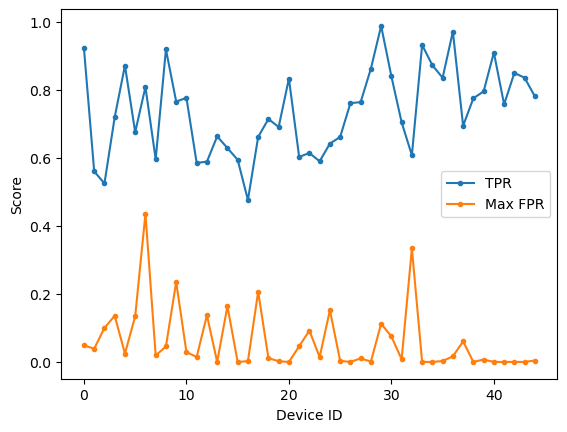

In [8]:
plt.plot(TPR.values(), label = "TPR",marker='.')
plt.plot(max_FPR.values(), label = "Max FPR",marker='.')
plt.legend()
plt.xlabel('Device ID')
plt.ylabel('Score') 
plt.savefig("Transformer.pdf", bbox_inches = "tight")
plt.show()

In [88]:
shared_items = {k: TPR[k] for k in TPR if k in max_FPR and TPR[k] > max_FPR[k]}
print(len(shared_items))

33


In [13]:
TPR.values()

dict_values([0.9217399301085157, 0.5602941176470588, 0.5245012411510527, 0.7193563218390805, 0.8711102927637636, 0.6753998896856039, 0.8083149374540103, 0.5955490160014714, 0.9187275903282155, 0.7653333333333333, 0.7763392326879677, 0.5848929839715904, 0.5887150945206794, 0.6631175059952038, 0.6287057469058812, 0.5942418426103647, 0.4760579598886863, 0.6613053415728435, 0.7141406448337141, 0.6905287400441417, 0.8328959620756793, 0.6026813880126183, 0.6142385507491747, 0.5897312859884837, 0.641746641074856, 0.6612794042985277, 0.7606551602676999, 0.7636794850076233, 0.8621010750867688, 0.9876951799049559, 0.8394146341463414, 0.7043325526932084, 0.6075121951219512, 0.9318284018346974, 0.8720119521912351, 0.8353017521090201, 0.9710249257626203, 0.6940184946740021, 0.7750097314130011, 0.7951290793960059, 0.9094427941308849, 0.7570438383292826, 0.8495814204698893, 0.8353598126632442, 0.7804504504504505])

/tmp/ipykernel_938666/2546608507.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation=0)


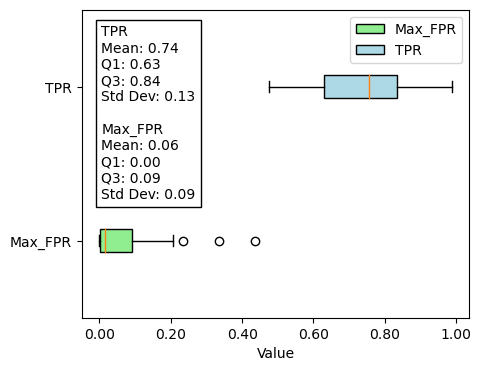

In [58]:
# Generate sample data

series1 = list(TPR.values())
series2 = list(max_FPR.values())

# Calculate statistics
series1_stats = {
    'mean': np.mean(series1),
    'q1': np.percentile(series1, 25),
    'q3': np.percentile(series1, 75),
    'std': np.std(series1)
}

series2_stats = {
    'mean': np.mean(series2),
    'q1': np.percentile(series2, 25),
    'q3': np.percentile(series2, 75),
    'std': np.std(series2)
}

# Create a figure and axis
fig, ax = plt.subplots(figsize=(5, 4))

# Plot the box plots
box_plot = ax.boxplot([series2, series1], patch_artist=True, vert=False)

# Customize the box colors
colors = ['lightgreen', 'lightblue']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)

# Add a red diamond for the means
#means = [series1_stats['mean'], series2_stats['mean']]
#ax.plot(means, [1, 2], marker='D', color='red', markersize=8)

# Set the axis labels and title
ax.set_xticklabels(ax.get_xticks(), rotation=0)
ax.set_yticklabels(['Max_FPR', 'TPR'], rotation=0)
ax.set_xlabel('Value')
#ax.set_title('Box Chart with Statistics')

# Add a legend
legend_text = ['Max_FPR', 'TPR']
ax.legend(box_plot['boxes'] + [ax.lines[0]], legend_text)

# Add text annotations for statistics
stats_text = (
    f"TPR\nMean: {series1_stats['mean']:.2f}\nQ1: {series1_stats['q1']:.2f}"
    f"\nQ3: {series1_stats['q3']:.2f}\nStd Dev: {series1_stats['std']:.2f}\n\n"
    f"Max_FPR\nMean: {series2_stats['mean']:.2f}\nQ1: {series2_stats['q1']:.2f}"
    f"\nQ3: {series2_stats['q3']:.2f}\nStd Dev: {series2_stats['std']:.2f}"
)
ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=10, va='top', bbox={'facecolor': 'white'})
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.2f}'))
plt.savefig("Box_plot.pdf", bbox_inches = "tight")
# Display the plot
plt.show()

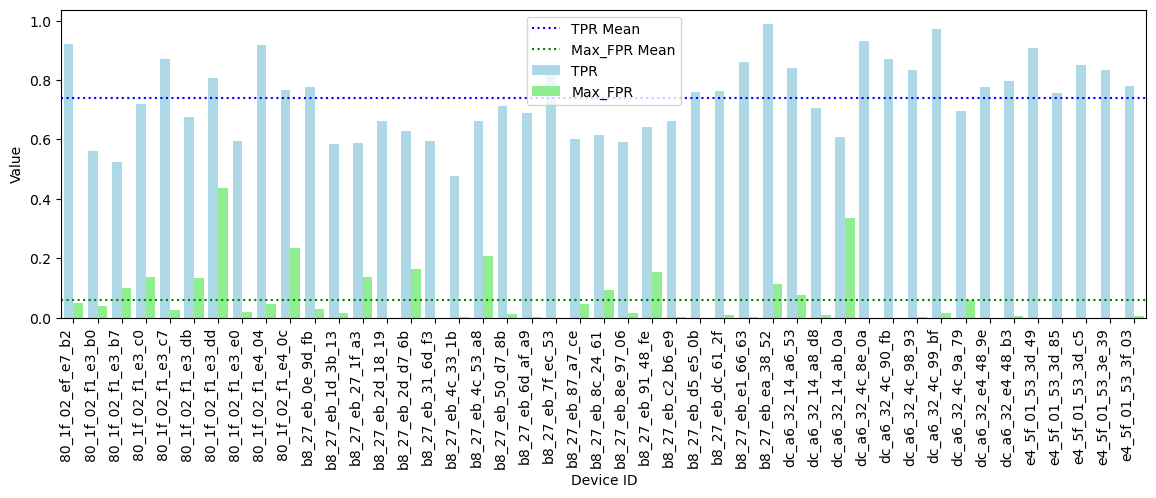

In [49]:
# Generate sample data

time_samples = np.arange(1, 46)
series1 = list(TPR.values())
series2 = list(max_FPR.values())


# Set the width of the bars
bar_width = 0.4

# Create a figure and axis
fig, ax = plt.subplots(figsize=(14, 4))


# Get the colors from the previous box plot
colors = ['lightblue', 'lightgreen']

# Plot the bars with the same colors
ax.bar(time_samples - bar_width/2, series1, bar_width, label='TPR', color=colors[0])
ax.bar(time_samples + bar_width/2, series2, bar_width, label='Max_FPR', color=colors[1])

series1_avg = np.mean(series1)
series2_avg = np.mean(series2)

# Plot the averages as a dotted line
ax.axhline(series1_avg, color='blue', linestyle='dotted', label='TPR Mean')
ax.axhline(series2_avg, color='green', linestyle='dotted', label='Max_FPR Mean')

# Set custom labels for the X-axis
ax.set_xticks(time_samples)
labels = [string[9:] for string in list(TPR.keys())]
ax.set_xticklabels(labels, rotation=90, ha='right')


# Set the axis labels and title
ax.set_xlabel('Device ID')
ax.set_ylabel('Value')

# Adjust the x-axis limits for better visibility
ax.set_xlim(0.5, 45.5)

# Add a legend
ax.legend()
plt.savefig("Bar_plot.pdf", bbox_inches = "tight")

# Display the plot
plt.show()


In [69]:
#Input shape 20,215
#Transformer 39: 10 epochs dff 32 layers 2 batch 128
#Transformer 38: 10 epochs dff 32 layers 1 batch 128
#Transformer 38: 10 epochs dff 32 layers 1 batch 64
#Transformer 36: 20 epochs dff 32 layers 1 batch 32
#Transformer 34: 20 epochs dff 32 layers 1 batch 64


#Input shape 10,215
#Transformer 34: 10 epochs dff 32 layers 1 batch 128
#Transformer 33: 10 epochs dff 32 layers 2 batch 128


#Input shape 50,215
#Transformer 43: 10 epochs dff 64 layers 2 batch 128
#Transformer 42: 10 epochs dff 32 layers 1 batch 128
#Transformer 42: 10 epochs dff 64 layers 1 batch 128

#Input shape 100,215
#Transformer 45: 50 epochs dff 32 layers 1 batch 192. Better average TPR y FPR test_model_transf_
#Transformer 45: 10 epochs dff 32 layers 1 batch 128
#Transformer 45: 10 epochs dff 64 layers 2 batch 128
#Transformer 44: 20 epochs dff 512 layers 1 batch 512
#Transformer 44: 20 epochs dff 256 layers 1 batch 512
#Transformer 43: 20 epochs dff 2048 layers 1 batch 512


In [ ]:
def create_denoising_autoencoder(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x = layers.LSTM(128, return_sequences=True)(inputs)
    x = layers.LSTM(64, return_sequences=False)(x)
    encoded = layers.Dense(32, activation='relu')(x)

    # Decoder
    x = layers.RepeatVector(input_shape[0])(encoded)
    x = layers.LSTM(64, return_sequences=True)(x)
    x = layers.LSTM(128, return_sequences=True)(x)
    decoded = layers.TimeDistributed(layers.Dense(input_shape[1], activation='linear'))(x)

    autoencoder = models.Model(inputs=inputs, outputs=decoded)
    return autoencoder

autoencoder = create_denoising_autoencoder(input_shape)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()



history = autoencoder.fit(X_train_noisy, X_train, epochs=100, batch_size=32,
                          validation_data=(X_test_noisy, X_test))


In [ ]:
input_shape = (10, 215)

# Sampling layer
class Sampling(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return mean + K.exp(0.5 * log_var) * epsilon

def create_variational_autoencoder(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x = layers.LSTM(128, return_sequences=True)(inputs)
    x = layers.LSTM(64, return_sequences=False)(x)
    x = layers.Dense(32)(x)

    z_mean = layers.Dense(16)(x)
    z_log_var = layers.Dense(16)(x)
    z = Sampling()([z_mean, z_log_var])

    # Decoder
    x = layers.Dense(64)(z)
    x = layers.RepeatVector(input_shape[0])(x)
    x = layers.LSTM(64, return_sequences=True)(x)
    x = layers.LSTM(128, return_sequences=True)(x)
    decoded = layers.TimeDistributed(layers.Dense(input_shape[1], activation='linear'))(x)

    vae = models.Model(inputs=inputs, outputs=decoded)

    # Define the VAE loss
    reconstruction_loss = losses.mean_squared_error(inputs, decoded)
    reconstruction_loss *= input_shape[0] * input_shape[1]
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    
    return vae

vae = create_variational_autoencoder(input_shape)
vae.compile(optimizer='adam')
vae.summary()

history = vae.fit(X_train, X_train, epochs=100, batch_size=32, validation_data=(X_test, X_test))




In [ ]:
def create_spatial_conv_autoencoder(input_shape=(10, 215, 1)):
    # Encoder
    encoder_input = layers.Input(shape=input_shape)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoder_input)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    decoder_input = layers.Input(shape=encoded.shape[1:])
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(decoder_input)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    # Autoencoder
    encoder = models.Model(encoder_input, encoded)
    decoder = models.Model(decoder_input, decoded)
    autoencoder = models.Model(encoder_input, decoder(encoded))

    return encoder, decoder, autoencoder

encoder, decoder, autoencoder = create_spatial_conv_autoencoder()
autoencoder.compile(optimizer='adam', loss='mse')


In [ ]:
# Assuming X is your input data with a shape of (num_samples, 10, 215)
X_reshaped = X.reshape(-1, 10, 215, 1)

autoencoder.fit(X_reshaped, X_reshaped, epochs=100, batch_size=32, validation_split=0.1)